In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, cohen_kappa_score, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import linregress, spearmanr
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor, callback
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

## Load the Data

In [2]:
index_cols = ["engine", "cycle"]
setting_cols = [f"op_setting_{i}" for i in range(1, 4)]
sensor = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "Bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow",
]
col_names = index_cols + setting_cols + sensor
train_file = "train_FD001.txt"
test_file = "test_FD001.txt"
rul_file = "RUL_FD001.txt"

train = pd.read_csv(train_file, sep=r"\s+", header=None, names=col_names, index_col=False)
test = pd.read_csv(test_file, sep=r"\s+", header=None, names=col_names, index_col=False)
rul = pd.read_csv(rul_file, sep=r"\s+", header=None, names=['RUL'], index_col=False)

In [3]:
train.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
if train.columns[-1].startswith('Unnamed'):
    train = train.iloc[:, :-1]
if test.columns[-1].startswith('Unnamed'):
    test = test.iloc[:, :-1]

In [5]:
train

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [6]:
test

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [7]:
train.shape

(20631, 26)

In [8]:
test.shape

(13096, 26)

In [9]:
rul.shape

(100, 1)

In [10]:
train.isna().sum()

,0
engine,0
cycle,0
op_setting_1,0
op_setting_2,0
op_setting_3,0
Fan inlet temperature (◦R),0
LPC outlet temperature (◦R),0
HPC outlet temperature (◦R),0
LPT outlet temperature (◦R),0
Fan inlet Pressure (psia),0


In [11]:
test.isna().sum()

,0
engine,0
cycle,0
op_setting_1,0
op_setting_2,0
op_setting_3,0
Fan inlet temperature (◦R),0
LPC outlet temperature (◦R),0
HPC outlet temperature (◦R),0
LPT outlet temperature (◦R),0
Fan inlet Pressure (psia),0


In [12]:
train.duplicated().sum()

np.int64(0)

In [13]:
test.duplicated().sum()

np.int64(0)

In [14]:
print("Number of engines in train dataset:", train['engine'].nunique())

Number of engines in train dataset: 100


In [15]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Fan inlet temperature (◦R),20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
LPC outlet temperature (◦R),20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPC outlet temperature (◦R),20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPT outlet temperature (◦R),20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Fan inlet Pressure (psia),20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


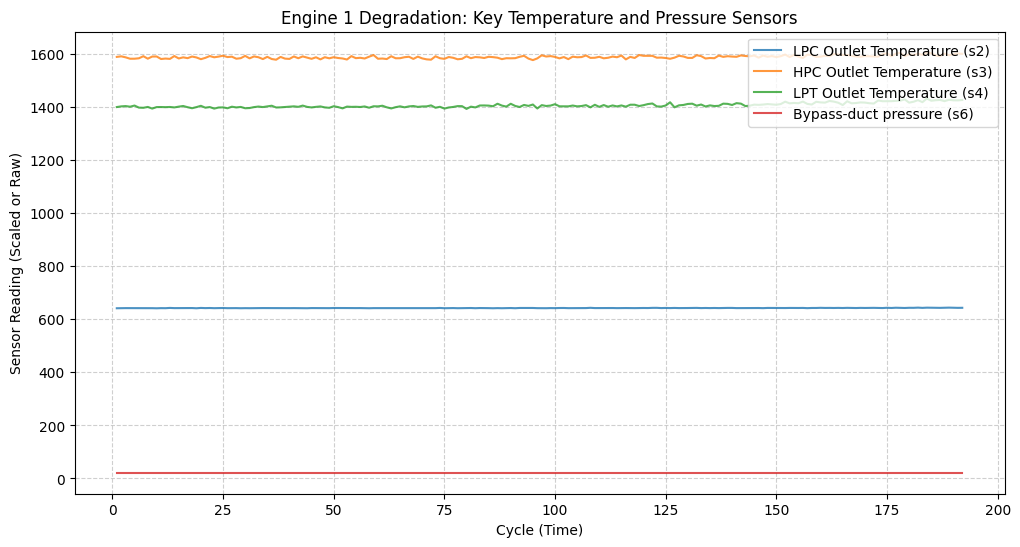

In [16]:
engine1 = train[train['engine']==1]
plt.figure(figsize=(12, 6))
plt.plot(engine1['cycle'], engine1['LPC outlet temperature (◦R)'], label='LPC Outlet Temperature (s2)', alpha=0.8)
plt.plot(engine1['cycle'], engine1['HPC outlet temperature (◦R)'], label='HPC Outlet Temperature (s3)', alpha=0.8)
plt.plot(engine1['cycle'], engine1['LPT outlet temperature (◦R)'], label='LPT Outlet Temperature (s4)', alpha=0.8)
plt.plot(engine1['cycle'], engine1['Bypass-duct pressure (psia)'], label='Bypass-duct pressure (s6)', alpha=0.8)

plt.xlabel("Cycle (Time)")
plt.ylabel("Sensor Reading (Scaled or Raw)")
plt.title("Engine 1 Degradation: Key Temperature and Pressure Sensors")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [17]:
#From the description of the dataframe we see some columns who seem to be constant (same min and max values) these wont help us so it is safe to drop them
nunique = train.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
print("Constant sensors:", constant_cols)

Constant sensors: ['op_setting_3', 'Fan inlet temperature (◦R)', 'Fan inlet Pressure (psia)', 'Engine pressure ratio (P50/P2)', 'Burner fuel-air ratio', 'Required fan speed', 'Required fan conversion speed']


In [18]:
train = train.drop(constant_cols , axis = 1)
test = test.drop(constant_cols , axis = 1)

In [19]:
train.shape

(20631, 19)

In [20]:
test.shape

(13096, 19)

In [21]:
train['max_cycle'] = train.groupby('engine')['cycle'].transform('max')
train['RUL'] = train['max_cycle'] - train['cycle']
train = train.drop('max_cycle', axis=1)
train

,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [22]:
rul_values= rul['RUL'].values
test['max_cycle'] = test.groupby('engine')['cycle'].transform('max')
test_rul = pd.DataFrame({"engine": test['engine'].unique(), "max_cycle": test.groupby('engine')['cycle'].max().values, "true_RUL": rul_values})

test= test.merge(test_rul, on=['engine', 'max_cycle'], how='left')
test['RUL'] = test['true_RUL'] + (test['max_cycle'] - test['cycle'])
test= test.drop(columns=['max_cycle', 'true_RUL'])
test


,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


## Exploratory Plots

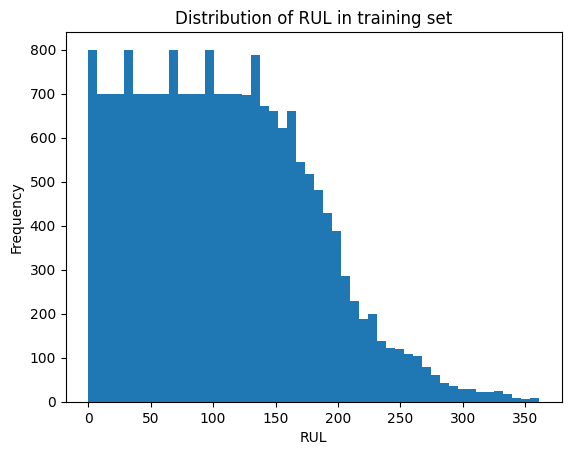

In [23]:
plt.hist(train['RUL'], bins=50)
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in training set")
plt.show()

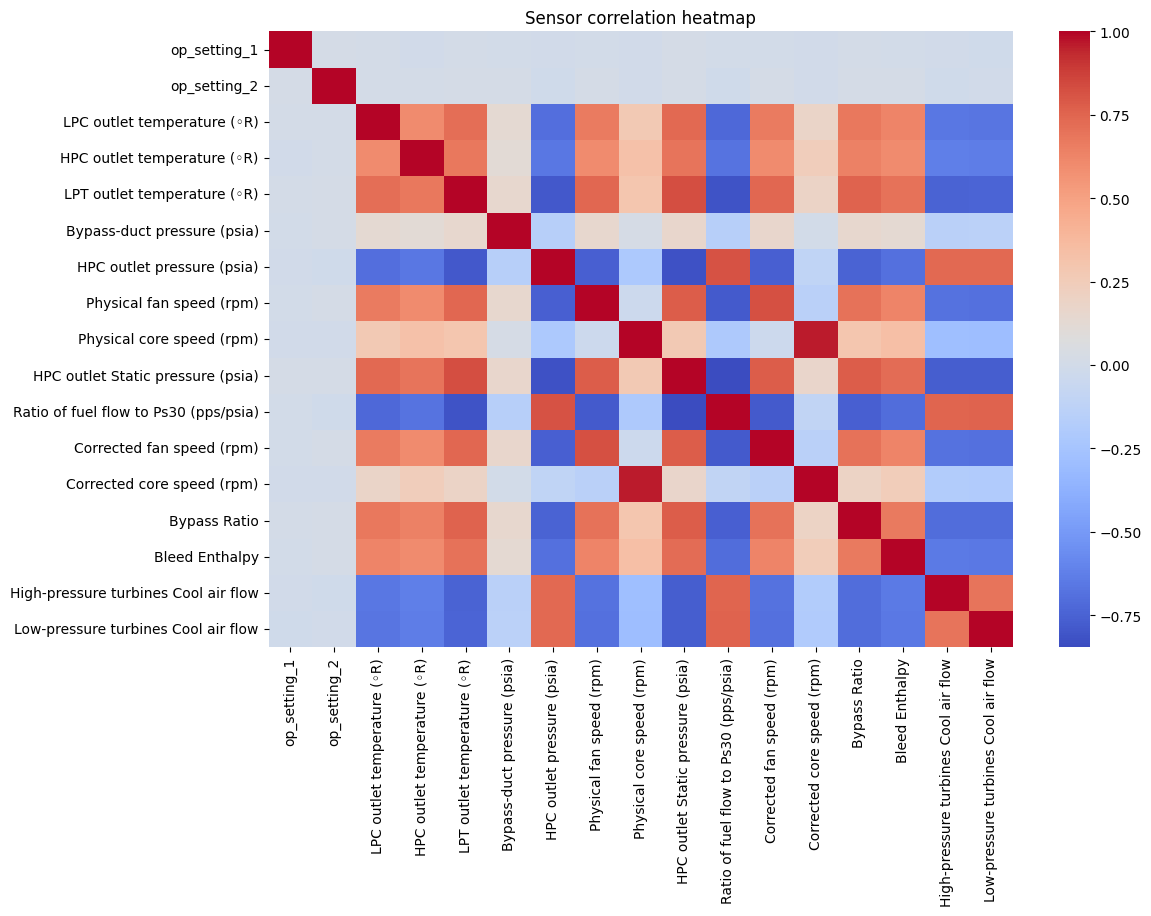

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(train.drop(columns=['engine','cycle','RUL']).corr(), cmap="coolwarm")
plt.title("Sensor correlation heatmap")
plt.show()

#Handling Outliers

In [25]:
useful_sensors = [
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Bleed Enthalpy",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow"
]

print("Useful  sensor names for modeling:")
for name in useful_sensors:
    print(f"- {name}")

Useful  sensor names for modeling:
- LPC outlet temperature (◦R)
- HPC outlet temperature (◦R)
- LPT outlet temperature (◦R)
- HPC outlet pressure (psia)
- Physical fan speed (rpm)
- Physical core speed (rpm)
- HPC outlet Static pressure (psia)
- Ratio of fuel flow to Ps30 (pps/psia)
- Corrected fan speed (rpm)
- Corrected core speed (rpm)
- Bypass Ratio
- Bleed Enthalpy
- High-pressure turbines Cool air flow
- Low-pressure turbines Cool air flow


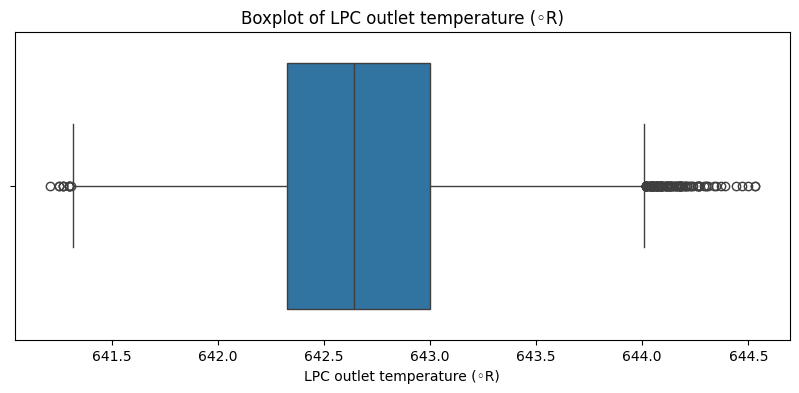

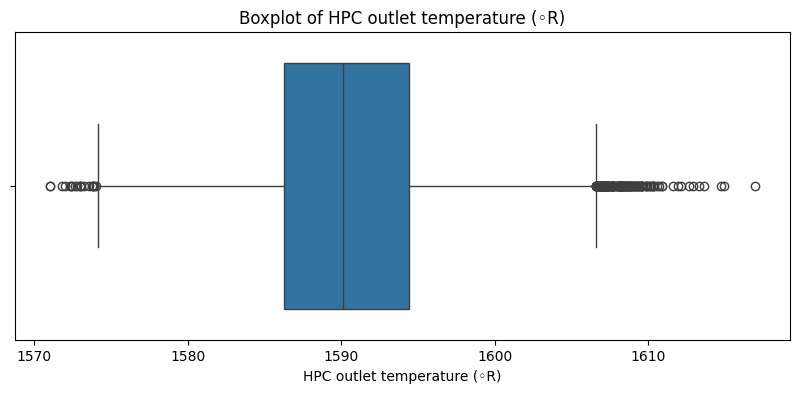

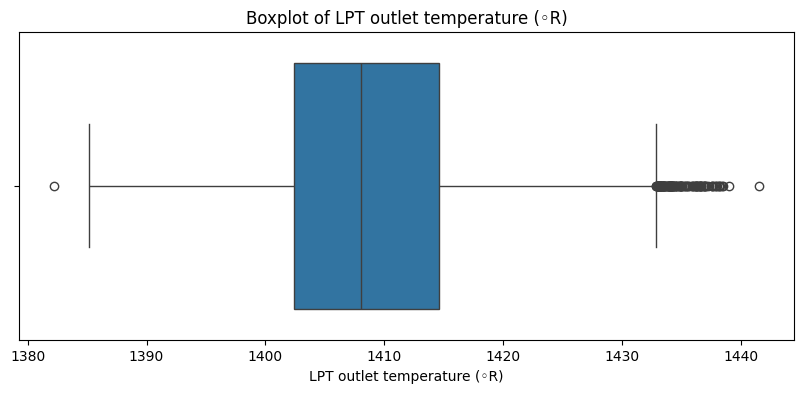

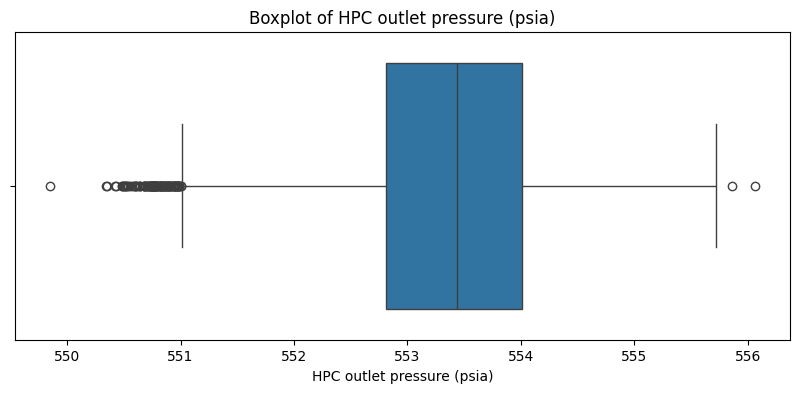

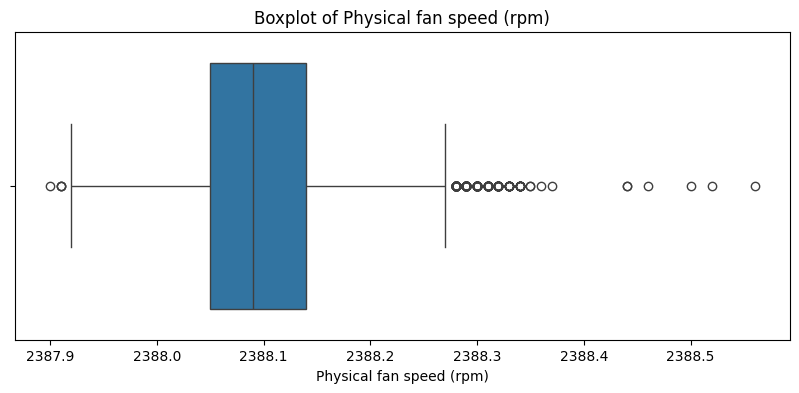

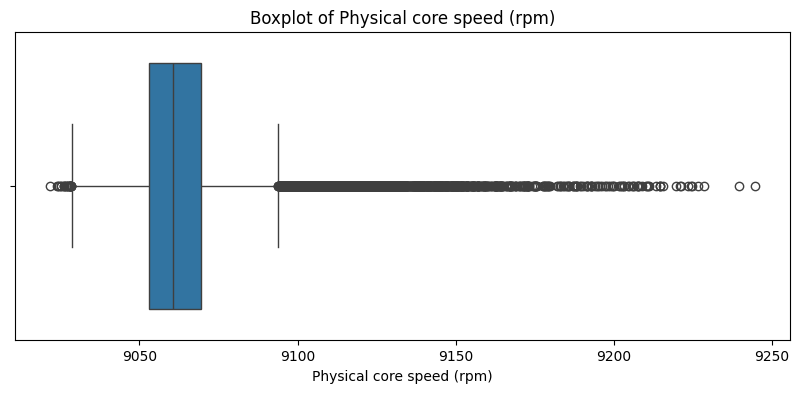

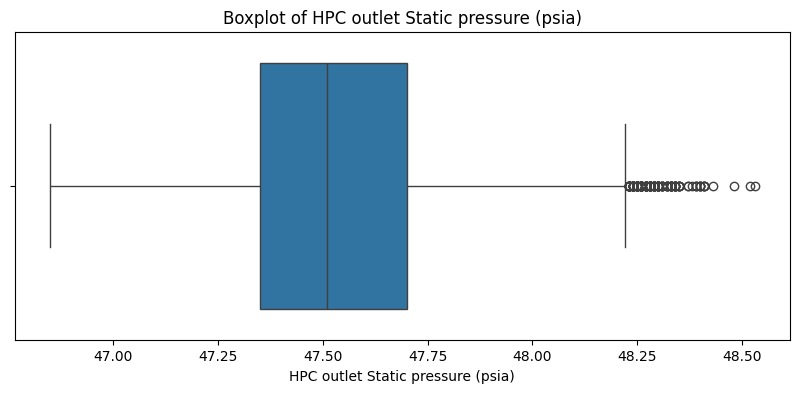

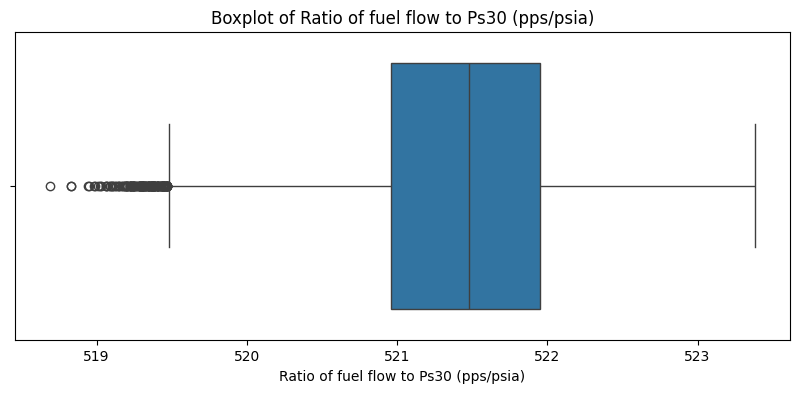

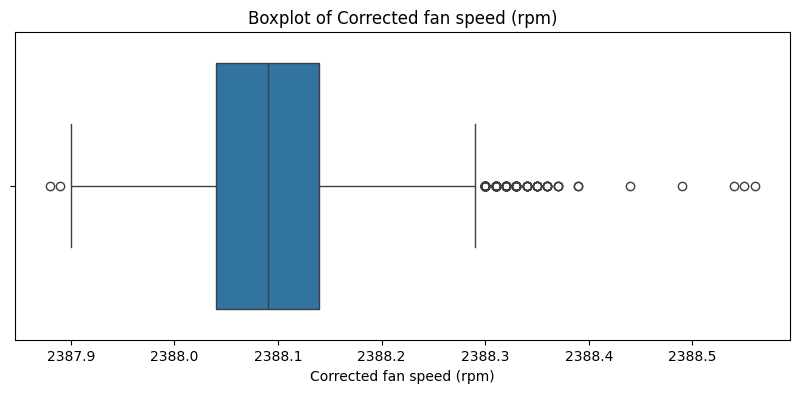

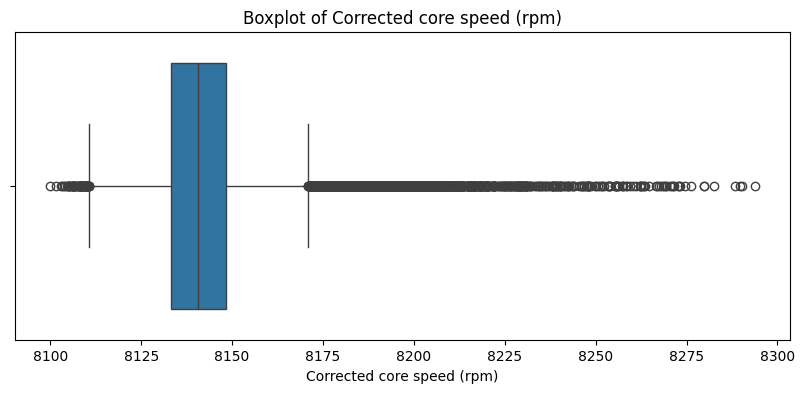

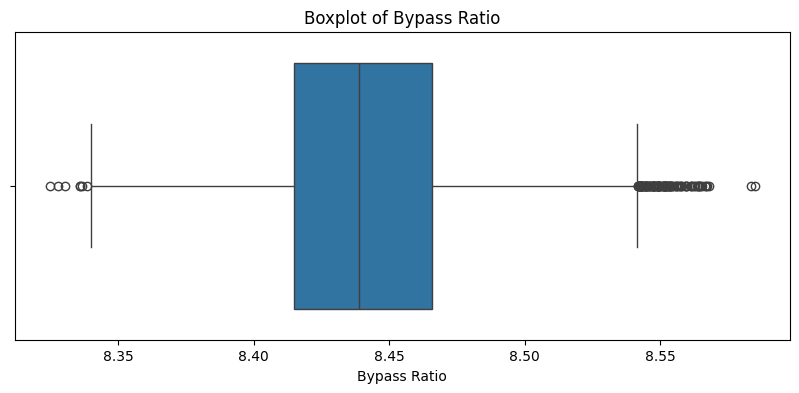

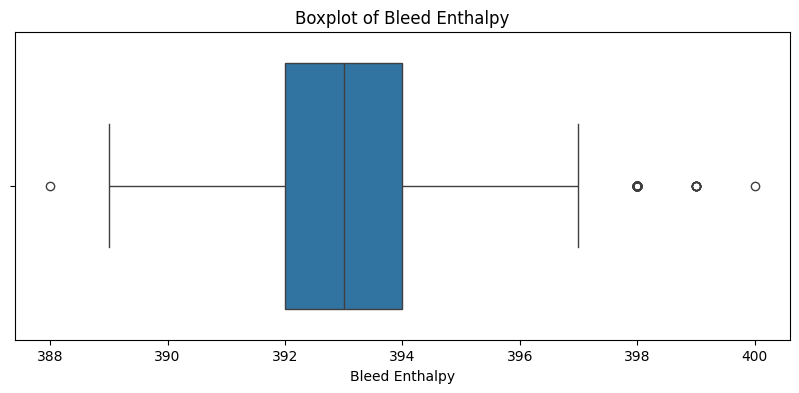

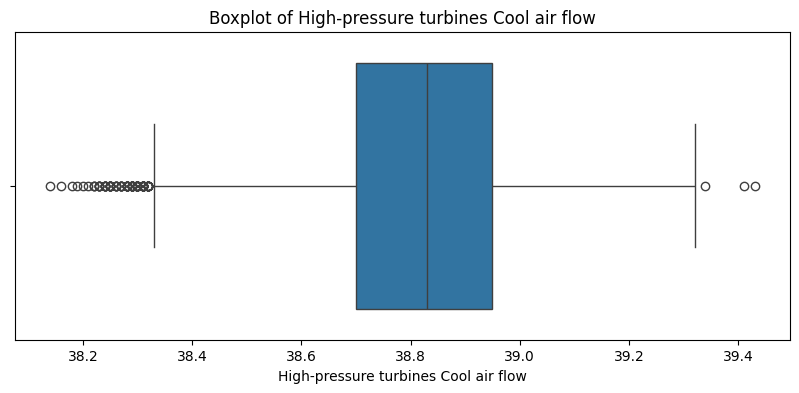

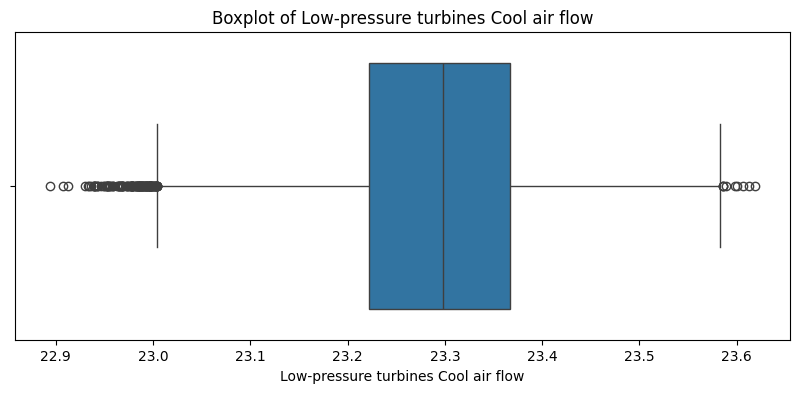

In [26]:
for col in useful_sensors:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=train[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [27]:
#Handling outliers is up for discussion as the outliers may be useful to show spikes that help in the occurence of failure and thats what helps us to detect
#for col in useful_sensors:
#    mean = train[col].mean()
#    std = train[col].std()
#    train[col+'_outlier'] = np.where(np.abs((train[col]-mean)/std) > 3, 1, 0)

## Simple Feature engineering

In [28]:
scaler = MinMaxScaler()
sensor_cols = [c for c in train.columns if c not in ['engine','cycle','RUL']]

train[sensor_cols] = scaler.fit_transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

rolling mean with window = 3 (look back 3 cycles each time), smoother and shows actual trends
Rolling standard deviation (std) → measures variability

If it’s high, the engine is unstable

Rolling min/max → captures recent extremes

Rolling sum → cumulative signal in the last N cycles

In [29]:
#short term trends
for col in useful_sensors:
    train[col+'_avg5'] = train.groupby('engine')[col].rolling(window=5, min_periods=1).mean().reset_index(0,drop=True)
    test[col+'_avg5'] = test.groupby('engine')[col].rolling(window=5, min_periods=1).mean().reset_index(0,drop=True)

In [30]:
for col in useful_sensors:
    train[col+'_std5'] = train.groupby('engine')[col].rolling(window=5, min_periods=1).std().reset_index(0,drop=True).fillna(0)
    test[col+'_std5'] = test.groupby('engine')[col].rolling(window=5, min_periods=1).std().reset_index(0,drop=True).fillna(0)

In [31]:
#delta features see how fast things change
for col in useful_sensors:
    train[col+'_diff'] = train.groupby('engine')[col].diff().fillna(0)
    test[col+'_diff'] = test.groupby('engine')[col].diff().fillna(0)

In [32]:
train['cycle_norm'] = train['cycle'] / train.groupby('engine')['cycle'].transform('max')
test['cycle_norm']  = test['cycle'] / test.groupby('engine')['cycle'].transform('max')

# Milestone 2

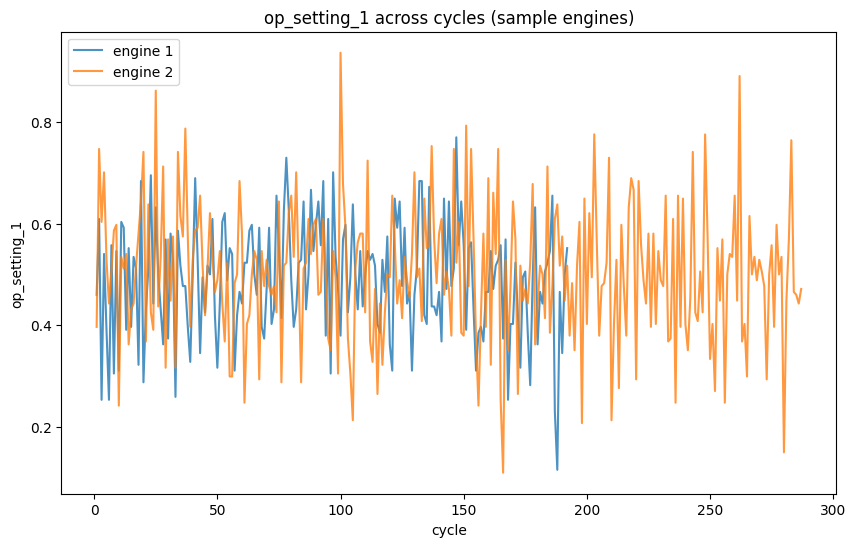

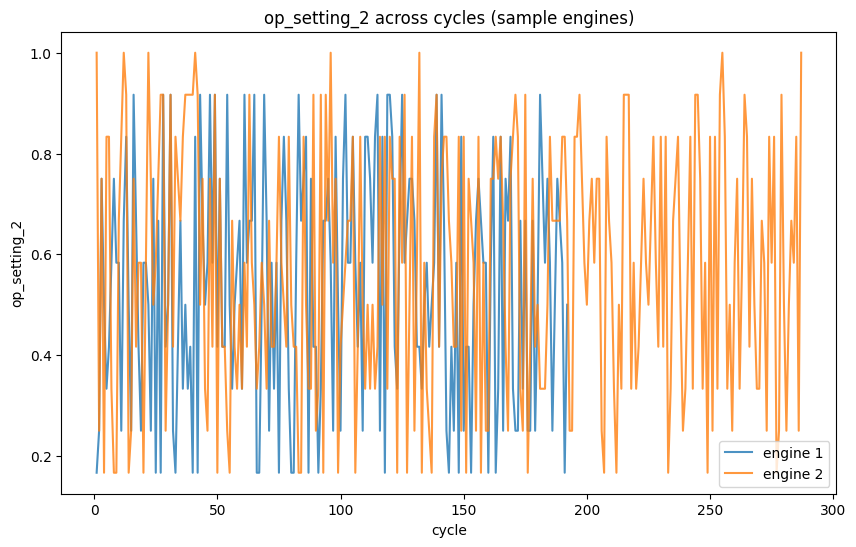

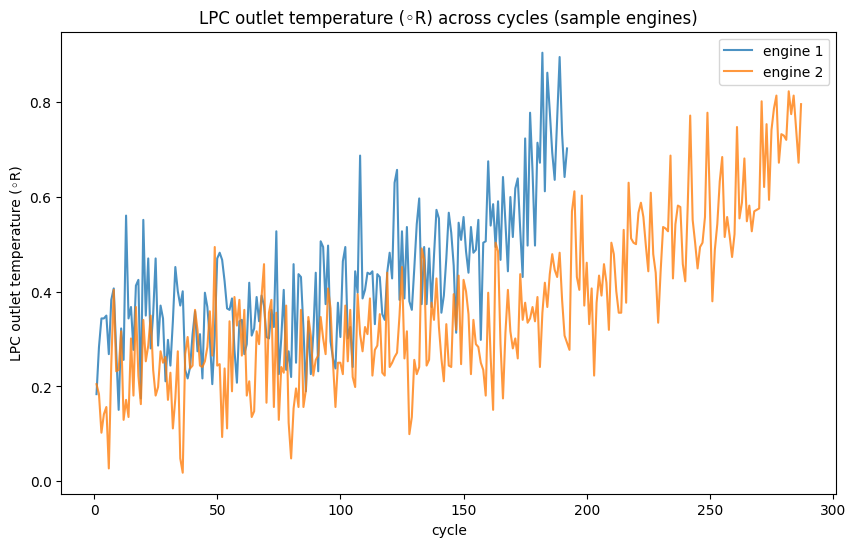

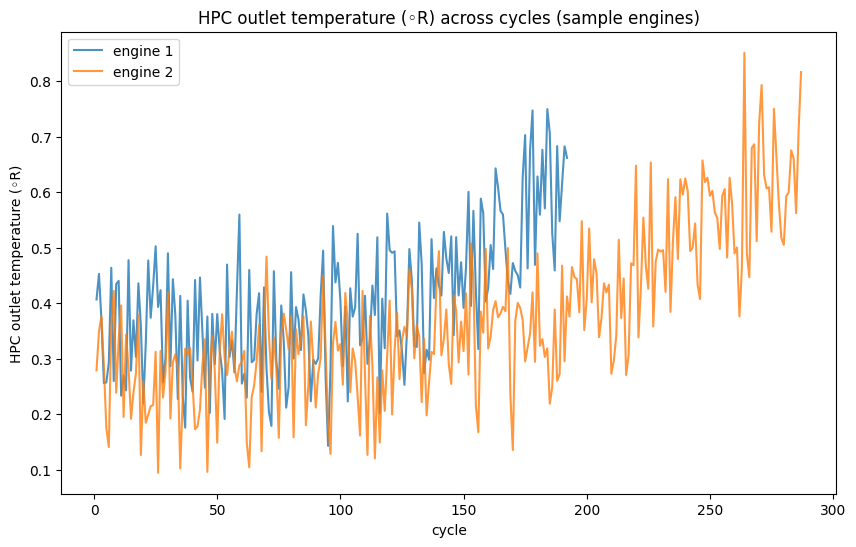

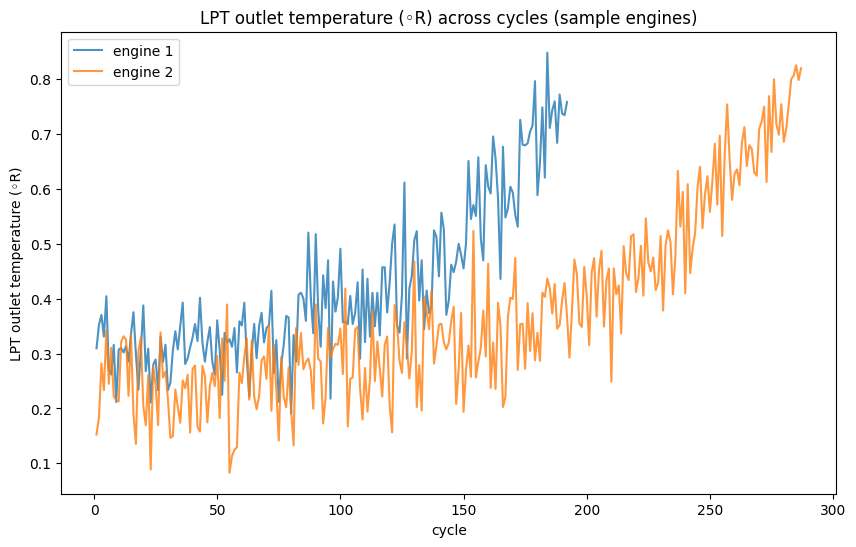

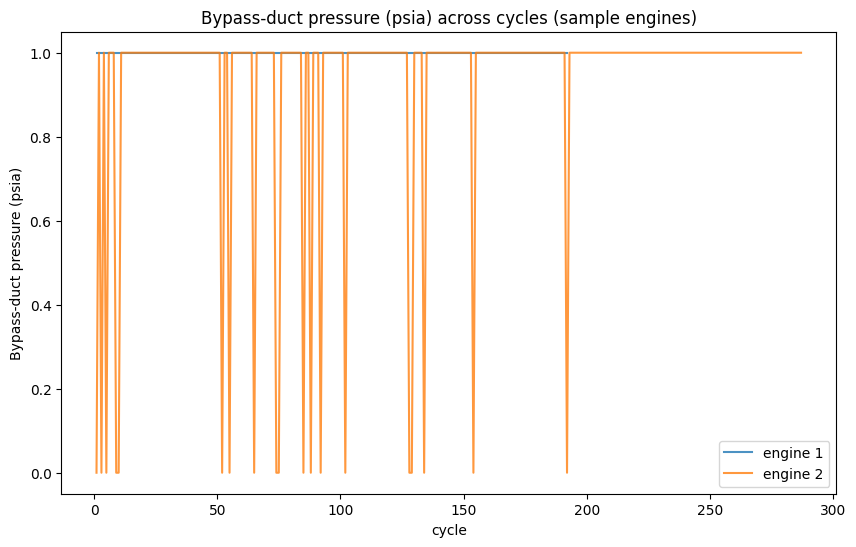

In [33]:
engines_to_plot=train['engine'].unique()[:2]
sensors_to_plot = sensor_cols[:6]

for sensor in sensors_to_plot:
    plt.figure(figsize=(10,6))
    for engine in engines_to_plot:
      eng =train[train['engine'] == engine]
      plt.plot(eng['cycle'], eng[sensor], label=f'engine {engine}', alpha=0.8)
    plt.title(f"{sensor} across cycles (sample engines)")
    plt.xlabel("cycle")
    plt.ylabel(sensor)
    plt.legend()
    plt.show()

In [34]:
results =[]
for sensor in sensor_cols:
  slopes =[]
  pvals = []
  for engine ,g in train.groupby('engine'):
    if len(g) <3:
      continue
    lr = linregress(g['cycle'], g[sensor])
    slopes.append(lr.slope)
    pvals.append(lr.pvalue)
  slopes = np.array(slopes)
  pvals = np.array(pvals)
  median_slope = np.median(slopes)
  mean_slope = np.mean(slopes)
  frac_pos = np.mean(slopes > 0)
  frac_neg = np.mean(slopes < 0)
  frac_sig = np.mean(pvals < 0.05)

  rho, sp_p = spearmanr(train[sensor],train['RUL'])
  results.append({'sensor': sensor,'median_slope': median_slope,'mean_slope': mean_slope,'frac_pos': frac_pos,'frac_neg': frac_neg,'frac_sig_slope': frac_sig,'spearman_rho_vs_RUL': rho,'spearman_p': sp_p})
deg_df = pd.DataFrame(results).sort_values(by='frac_sig_slope', ascending=False)
deg_df.reset_index(drop=True, inplace=True)
deg_df.head(20)


,sensor,median_slope,mean_slope,frac_pos,frac_neg,frac_sig_slope,spearman_rho_vs_RUL,spearman_p
0,LPC outlet temperature (◦R),1.596674e-03,0.001653,1.00,0.00,1.00,-0.628588,0.000000e+00
1,High-pressure turbines Cool air flow,-1.562337e-03,-0.001616,0.00,1.00,1.00,0.653336,0.000000e+00
2,HPC outlet temperature (◦R),1.419136e-03,0.001420,1.00,0.00,1.00,-0.605609,0.000000e+00
3,LPT outlet temperature (◦R),1.844902e-03,0.001872,1.00,0.00,1.00,-0.701771,0.000000e+00
4,HPC outlet pressure (psia),-1.595802e-03,-0.001699,0.00,1.00,1.00,0.678845,0.000000e+00
5,Physical fan speed (rpm),1.056896e-03,0.001102,1.00,0.00,1.00,-0.573864,0.000000e+00
6,Bleed Enthalpy,1.414599e-03,0.001418,1.00,0.00,1.00,-0.629397,0.000000e+00
7,Ratio of fuel flow to Ps30 (pps/psia),-1.802467e-03,-0.001926,0.00,1.00,1.00,0.693149,0.000000e+00
8,HPC outlet Static pressure (psia),1.984857e-03,0.002010,1.00,0.00,1.00,-0.718132,0.000000e+00
9,Bypass Ratio,1.641923e-03,0.001684,1.00,0.00,1.00,-0.665905,0.000000e+00


1. Focus on slope direction & significance

A sensor shows degradation if it has a consistent slope (positive or negative) across engines.

frac_pos close to 1.0 → mostly positive slopes (sensor increases as cycles increase).

frac_neg close to 1.0 → mostly negative slopes (sensor decreases with cycles).

frac_sig_slope close to 1.0 → slopes are statistically significant (reliable trend).

s2, s3, s4, s8, s11, s13, s15, s17 have positive consistent slopes → they increase as the engine degrades.

s7, s12, s20, s21 have negative consistent slopes → they decrease as the engine degrades.

2. Check correlation with RUL (Remaining Useful Life)

spearman_rho_vs_RUL tells how strongly the sensor correlates with RUL.

Negative correlation → as RUL decreases (engine approaches failure), sensor value increases.

Positive correlation → as RUL decreases, sensor value decreases.


Strong negative correlations (good candidates): s2, s3, s4, s8, s11, s13, s15, s17.

Strong positive correlations: s7, s12, s20, s21.

Both are valid → what matters is consistency.

3. Decide useful vs. useless sensors

Useful sensors: high |rho| (≥0.5), frac_sig_slope ~ 1, consistent slope.

Weak sensors: very small slopes, low correlation, inconsistent sign.

From our output, the most useful sensors are:
s2, s3, s4, s7, s8, s11, s12, s13, s15, s17, s20, s21.

We can Drop the weak ones

s6, s14, s9 are borderline (weak correlation).

op_setting_1, op_setting_2 are not sensors

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(train[sensor_cols])
pca = PCA(n_components=None)
X = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
print("Explained variance ratio:", explained)
print("Cumulative:", np.cumsum(explained))

Explained variance ratio: [0.50978998 0.17019244 0.06148257 0.05277026 0.04511109 0.02296592
 0.02089122 0.01896348 0.01777373 0.01674084 0.01497876 0.01247696
 0.01185749 0.01054707 0.00700629 0.0056366  0.00081531]
Cumulative: [0.50978998 0.67998242 0.74146499 0.79423525 0.83934633 0.86231225
 0.88320347 0.90216695 0.91994068 0.93668152 0.95166027 0.96413723
 0.97599472 0.9865418  0.99354809 0.99918469 1.        ]


In [36]:
for i in range(X_pca.shape[1]):
    train[f'PC{i+1}'] = X_pca[:, i]

pc_corrs = []
for i in range(X_pca.shape[1]):
    rho, pval = spearmanr(train[f'PC{i+1}'], train['RUL'])
    pc_corrs.append((i+1, rho, pval))

pc_corrs_df = pd.DataFrame(pc_corrs, columns=['PC','spearman_rho_vs_RUL','pval'])

In [37]:
pc1 = X_pca[:, 0]
HI = 1 - (pc1 - pc1.min()) / (pc1.max() - pc1.min())
train['HI'] = HI

In [38]:
X_test_prep = imputer.transform(test[sensor_cols])
X_test_prep = scaler.transform(X_test_prep)
X_test_pca  = pca.transform(X_test_prep)

for i in range(X_test_pca.shape[1]):
    test[f'PC{i+1}'] = X_test_pca[:, i]

pc1_test = X_test_pca[:, 0]
HI_test = 1 - (pc1_test - pc1.min()) / (pc1.max() - pc1.min())
test['HI'] = HI_test


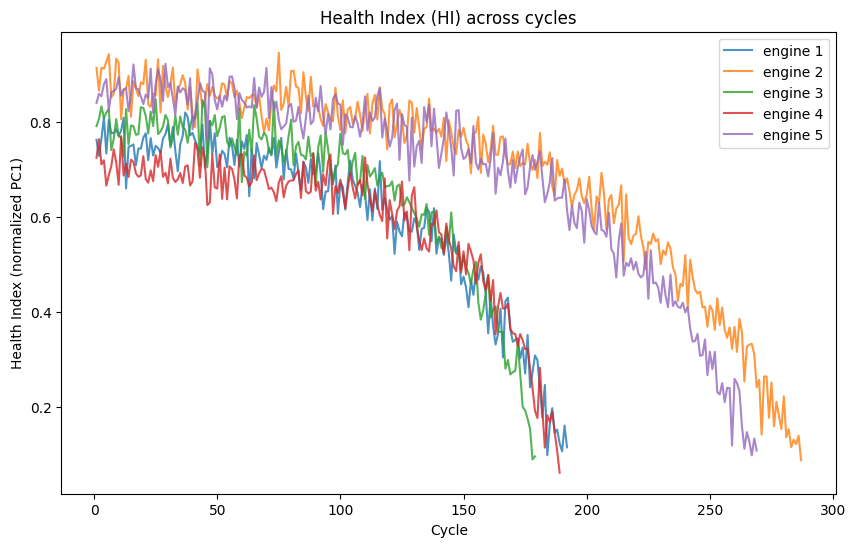

In [39]:
engines_to_plot = train['engine'].unique()[:5]  # first 5 engines for example

plt.figure(figsize=(10,6))
for engine in engines_to_plot:
    eng = train[train['engine'] == engine]
    plt.plot(eng['cycle'], eng['HI'], label=f'engine {engine}', alpha=0.8)

plt.title("Health Index (HI) across cycles")
plt.xlabel("Cycle")
plt.ylabel("Health Index (normalized PC1)")
plt.legend()
plt.show()


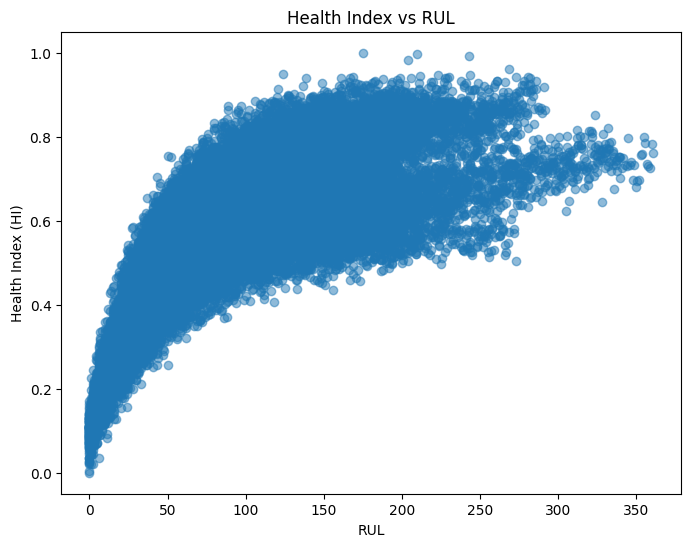

Spearman correlation between HI and RUL: 0.7643845693427276 p-value: 0.0


In [40]:
plt.figure(figsize=(8,6))
plt.scatter(train['RUL'], train['HI'], alpha=0.5)
plt.title("Health Index vs RUL")
plt.xlabel("RUL")
plt.ylabel("Health Index (HI)")
plt.show()

rho, pval = spearmanr(train['HI'], train['RUL'])
print("Spearman correlation between HI and RUL:", rho, "p-value:", pval)

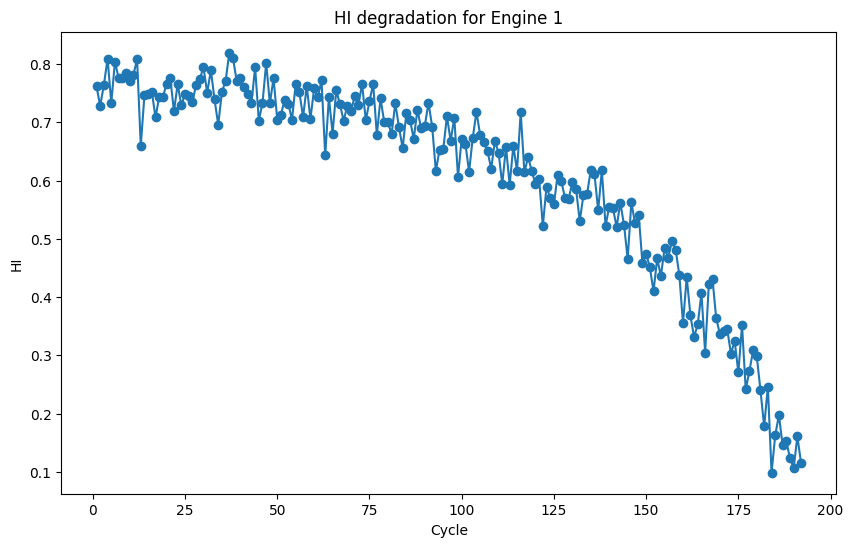

In [41]:
engine_id = 1
eng = train[train['engine'] == engine_id]

plt.figure(figsize=(10,6))
plt.plot(eng['cycle'], eng['HI'], marker='o')
plt.title(f"HI degradation for Engine {engine_id}")
plt.xlabel("Cycle")
plt.ylabel("HI")
plt.show()


## Milestone 3

Regression

In [42]:
useful_features = ['cycle_norm', 'HI'] + [
    'LPC outlet temperature (◦R)',
    'HPC outlet temperature (◦R)',
    'LPT outlet temperature (◦R)',
    'Bypass-duct pressure (psia)',
    'HPC outlet pressure (psia)',
    'Physical fan speed (rpm)',
    'Physical core speed (rpm)',
    'Ratio of fuel flow to Ps30 (pps/psia)',
    'Corrected fan speed (rpm)',
    'Corrected core speed (rpm)',
    'Bypass Ratio'
]

X = train[useful_features]
y = train['RUL']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)


X_train: (16504, 13) y_train: (16504,)
X_val: (4127, 13) y_val: (4127,)


In [43]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)

    results[name] = {"RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T
print(results_df)


                        RMSE        R2
Linear Regression  28.000860  0.828391
Random Forest      28.151248  0.826542
Gradient Boosting  27.546851  0.833910


### XGBOOST

In [67]:
feature_cols = [c for c in train.columns if c not in ['engine','cycle','RUL']]
X = train[feature_cols]
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.0,
    reg_alpha=0.0
)

In [69]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"XGBoost RMSE: {rmse:.4f}")
print(f"XGBoost R²: {r2:.4f}")

[0]	validation_0-rmse:64.58979
[50]	validation_0-rmse:21.86581
[100]	validation_0-rmse:20.76243
[150]	validation_0-rmse:20.40352
[200]	validation_0-rmse:20.20316
[250]	validation_0-rmse:20.12686
[300]	validation_0-rmse:20.06203
[350]	validation_0-rmse:19.93021
[400]	validation_0-rmse:19.86539
[450]	validation_0-rmse:19.78932
[499]	validation_0-rmse:19.72870
XGBoost RMSE: 19.7287
XGBoost R²: 0.9148


### LSTM

In [ ]:
#There are 2 methods to use LSTM, I will use the sliding window method as it looks at the last N cycles, The other method would be unhelpful as it will look at all cycles
"""def create_sequences(df, seq_len, features, target_col='RUL'):
    X, y = [], []
    for eng_id, eng_df in df.groupby('id'):
        eng_df = eng_df.reset_index(drop=True)
        values = eng_df[features].values
        targets = eng_df[target_col].values

        for i in range(len(eng_df) - seq_len + 1):
            X.append(values[i:i+seq_len])
            y.append(targets[i+seq_len-1])  # predict last cycle RUL

    return np.array(X), np.array(y) """

In [ ]:
"""seq_len = 50
useful_sensors = ['s2','s3','s4','s7','s8','s11','s12','s15','s17','s20','s21']  # from your degradation study
features = useful_sensors + ['cycle_norm']

X_train, y_train = create_sequences(train, seq_len, features)
X_test, y_test   = create_sequences(test, seq_len, features)"""

In [ ]:
#X_test = X_test[X_train.columns]

In [ ]:
#print("Train shape:", X_train.shape, y_train.shape)
#print("Test shape:", X_test.shape, y_test.shape)

In [ ]:
"""model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_len, len(features))),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_lstm.h5', monitor='val_loss', save_best_only=True)
]"""

In [ ]:
"""history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM R²:   {r2:.4f}")"""

## Regression Model Optimization

In [70]:
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)
print("Best Params:", rf_random.best_params_)

best_rf = rf_random.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}


In [71]:
y_pred = best_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Optimized RF RMSE:", rmse)
print("Optimized RF R²:", r2)

Optimized RF RMSE: 18.56136830395854
Optimized RF R²: 0.9245918488542726


In [72]:
xgb = XGBRegressor(random_state=42, n_jobs=-1)

param_dist_xgb = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 5, 10]
}

xgb_random = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train, y_train)
print("Best Params:", xgb_random.best_params_)

best_xgb = xgb_random.best_estimator_

y_pred = best_xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Optimized XGB RMSE:", rmse)
print("Optimized XGB R²:", r2)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Optimized XGB RMSE: 18.32792852089912
Optimized XGB R²: 0.9264766573905945
